In [18]:
import pandas as pd
import numpy as np
import random
from collections import defaultdict, Counter
import scipy.optimize
import numpy
import random
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, balanced_accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('for_reviews_acc.csv').dropna()
data.head(5)

,user_id,item_id,playtime_forever,play_after_buy,review,fix_recommend,review_label
0,76561197970982479,22200,271,True,It's unique and worth a playthrough.,True,1
1,76561197970982479,1250,10006,True,Simple yet with great replayability. In my opi...,True,1
2,76561197970982479,43110,834,True,Great atmosphere. The gunplay can be a bit chu...,True,1
3,js41637,227300,551,True,For a simple (it's actually not all that simpl...,True,1
4,js41637,239030,349,True,Very fun little game to play when your bored o...,True,1


In [4]:
len(data)

44166

### Split Dataset

In [5]:
def splitData(X, y, p1, p2, balance=False): 
    X = np.array(X)
    y = np.array(y)

    if balance:
        total = len(y)
        n = round(len(y)*p1/2)

        idx = []
        while len(idx) < n:
            i = random.choice(range(total))
            if y[i] == 1:
                idx.append(i)
        X_test = X[idx]
        y_test = y[idx]
        X = np.delete(X, idx, 0)
        y = np.delete(y, idx, 0)
        
        idx = []
        total = len(y)
        while len(idx) < n:
            i = random.choice(range(total))
            if y[i] == 0:
                idx.append(i)
        X_test = np.concatenate((X_test,X[idx]), axis=0)
        y_test = np.concatenate((y_test,y[idx]), axis=0)
        X = np.delete(X, idx, 0)
        y = np.delete(y, idx, 0)

    else:
        sss = StratifiedShuffleSplit(n_splits=5, test_size=p1)
        for train_index, test_index in sss.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        X = X_train
        y = y_train

    sss = StratifiedShuffleSplit(n_splits=5, test_size=p2)
    
    for train_index, test_index in sss.split(X, y):
        X_train, X_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]

    print(len(y_train), len(y_valid), len(y_test))
    print(sum([len(y_train), len(y_valid), len(y_test)]))
    return X_train, y_train, X_valid, y_valid, X_test, y_test
    

In [6]:
labels = data['fix_recommend'].to_list()

In [7]:
data_train, y_train, data_valid, y_valid, data_test, y_test = splitData(data, labels, .1, .15, False)

33786 5963 4417
44166


In [8]:
data_train[0]

array(['76561197981203305', 33980, 92, True,
       'The pacing with this game is all off.Most of it is slow and tedious, others are suddenly fast and annoying.The humour in it felt forced too.',
       False, 1], dtype=object)

### Index:

0:  user_id	
1:  item_id	
2:  playtime_forever	
3:  play_after_buy	
4:  review	
5:  fix_recommend	
6:  review_label

In [9]:
def evaluate(y1,y2,detail=False):
    if not detail:
        return accuracy_score(y1,y2), f1_score(y1,y2), 1-balanced_accuracy_score(y1,y2)
    else:
        TN, FP, FN, TP = confusion_matrix(y1,y2).ravel()
        BER = (FP/(TN+FP) + FN/(FN+TP))/2
        PREC = TP/(TP+FP)
        RECALL = TP/(TP+FN)
        F1 = 2*(PREC*RECALL)/(PREC+RECALL)
        Acc = accuracy_score(y1,y2)
        return TN,FP,FN,TP,BER,PREC,RECALL,F1,Acc


### 1. Feature-based regression

In [10]:
review_emo_per_game = defaultdict(list)
review_emo_per_user = defaultdict(list)

for row in data_train:
    review_emo_per_user[row[0]].append(row[-1])
    review_emo_per_game[row[1]].append(row[-1])

In [11]:
review_avg_emo_per_game = defaultdict(int)
review_avg_emo_per_user = defaultdict(int)

for user in review_emo_per_user.keys():
    rates = review_emo_per_user[user]
    review_avg_emo_per_user[user] = sum(rates)/len(rates)
for item in review_emo_per_game.keys():
    rates = review_emo_per_game[item]
    review_avg_emo_per_game[item] = sum(rates)/len(rates)

In [12]:
review_avg_emo_all_user = sum(review_avg_emo_per_user.values()) / len(review_avg_emo_per_user)
review_avg_emo_all_game = sum(review_avg_emo_per_game.values()) / len(review_avg_emo_per_game)
review_avg_emo_all_user, review_avg_emo_all_game

(0.847868869915394, 0.8188504283703703)

In [13]:
def cleanData(data):
    # review_label, review_avg_emo_per_user, review_avg_emo_per_game
    res = []
    for row in data:
        tmp = [row[-1]]
        if row[0] in review_avg_emo_per_user:
            tmp.append(review_avg_emo_per_user[row[0]])
        else:
            print(row[0],row[1],'user miss!')
            tmp.append(review_avg_emo_all_user)
        if row[1] in review_avg_emo_per_game:
            tmp.append(review_avg_emo_per_game[row[1]])
        else:
            print(row[0],row[1],'game miss!')
            tmp.append(review_avg_emo_all_game)
        res.append(tmp)
    return res

In [14]:
train_clean = cleanData(data_train)
valid_clean = cleanData(data_valid)
test_clean = cleanData(data_test)
# train_clean[:5],valid_clean[:5],test_clean[:5]

MilfHunterXFuckTightTeenPussy 394230 user miss!
halfroastedunircornmeat 218620 user miss!
lepiglet47 261700 user miss!
76561198019669521 8970 user miss!
76561198019669521 8970 game miss!
76561198065145032 227300 user miss!
76561198029779195 413150 user miss!
Aluriana 285920 user miss!
viny143 240 user miss!
76561198096332661 218620 user miss!
falcodark 218620 user miss!
76561198069090454 246420 user miss!
76561198078112264 4000 user miss!
76561198245310554 730 user miss!
jubabies 230410 user miss!
couchguy123 42680 user miss!
AndoCommando24 218620 user miss!
76561197995958796 299890 user miss!
76561197995958796 299890 game miss!
therealmorty 351570 user miss!
nerfdarius 730 user miss!
bobby09890 72850 user miss!
Macindroid 245470 user miss!
76561198019568583 287700 user miss!
thextractx 72850 user miss!
Bird_Of_PrAy 262410 user miss!
nige72 4000 user miss!
eEssiEe 730 user miss!
76561198065955655 206420 user miss!
Meph-- 244870 user miss!
nutinme 730 user miss!
76561198071475367 12160 

balanced

In [15]:
c_list = [1e-10,1e-8,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10]
res1_valid = []
for c in c_list:
    # 记得再考虑 balance！！！！
    reg = linear_model.LogisticRegression(C=c, random_state=0, class_weight='balanced').fit(train_clean, y_train)
    y1_valid = reg.predict(valid_clean)
    acc, F1, BER= evaluate(y_valid,y1_valid)
    res1_valid.append((acc, F1, BER, c))


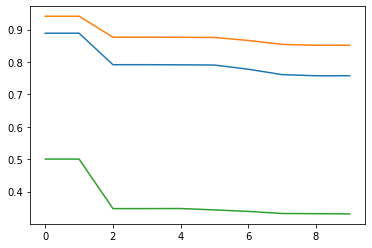

In [16]:
x = list(range(len(c_list)))
res1_valid = np.array(res1_valid)
plt.plot(x,res1_valid[:,0],x,res1_valid[:,1],x,res1_valid[:,2])

In [17]:
pd.DataFrame(res1_valid,columns = ['acc', 'F1', 'BER','c'])

,acc,F1,BER,c
0,0.888479,0.940947,0.500094,1.000000e-10
1,0.888479,0.940947,0.500094,1.000000e-08
2,0.791380,0.876244,0.347251,1.000000e-06
3,0.791380,0.876244,0.347251,1.000000e-05
4,0.791045,0.876020,0.347440,1.000000e-04
5,0.790374,0.875399,0.343207,1.000000e-03
6,0.777461,0.866216,0.338616,1.000000e-02
7,0.760859,0.854073,0.332150,1.000000e-01
8,0.757169,0.851365,0.331591,1.000000e+00
9,0.757337,0.851453,0.330838,1.000000e+01


imbalanced

In [18]:
c_list = [1e-3,1e-2,1e-1,1,10]
res1_valid = []
for c in c_list:
    # 记得再考虑 balance！！！！
    reg = linear_model.LogisticRegression(C=c, random_state=0).fit(train_clean, y_train)
    y1_valid = reg.predict(valid_clean)
    acc, F1, BER= evaluate(y_valid,y1_valid)
    res1_valid.append((acc, F1, BER, c))

In [19]:
pd.DataFrame(res1_valid,columns = ['acc', 'F1', 'BER','c'])

,acc,F1,BER,c
0,0.888647,0.941041,0.500000,0.001
1,0.888647,0.941041,0.500000,0.010
2,0.888479,0.940926,0.498777,0.100
3,0.888479,0.940926,0.498777,1.000
4,0.888647,0.941009,0.498024,10.000


In [16]:
c = 1e-3
reg = linear_model.LogisticRegression(C=c, random_state=0, class_weight='balanced').fit(train_clean, y_train)
y1_test = reg.predict(test_clean)
acc, F1, BER= evaluate(y_test,y1_test)
res2_test=(acc, F1, BER, c)

pd.DataFrame([res2_test],columns = ['acc', 'F1', 'BER','c'])

,acc,F1,BER,c
0,0.792393,0.876698,0.34042,0.001


In [21]:
c = 1
reg = linear_model.LogisticRegression(C=c, random_state=0).fit(train_clean, y_train)
y1_test = reg.predict(test_clean)
acc, F1, BER= evaluate(y_test,y1_test)
res2_test=(acc, F1, BER, c)

pd.DataFrame([res2_test],columns = ['acc', 'F1', 'BER','c'])

,F1,acc,BER,Precision,Recall,c
0,0.94112,0.888839,0.498218,0.889191,0.999491,1


In [22]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
d_list = [2,3,4,5,6]
res2_valid = []
for d in d_list:
    clf = RandomForestClassifier(max_depth=d, random_state=0, class_weight='balanced')
    clf.fit(train_clean, y_train)

    y2_valid = clf.predict(valid_clean)
    acc, F1, BER= evaluate(y_valid,y2_valid)
    res2_valid.append((acc, F1, BER, d))

pd.DataFrame(res2_valid,columns = ['acc', 'F1', 'BER','d'])

,acc,F1,BER,d
0,0.743585,0.842647,0.357677,2
1,0.713064,0.820405,0.372215,3
2,0.715747,0.823235,0.385854,4
3,0.743585,0.843868,0.382705,5
4,0.753144,0.850861,0.383914,6


In [24]:
d_list = [2,4,8,10,20,30,40,50]
res2_valid = []
for d in d_list:
    clf = RandomForestClassifier(max_depth=d, random_state=0)
    clf.fit(train_clean, y_train)

    y2_valid = clf.predict(valid_clean)
    acc, F1, BER= evaluate(y_valid,y2_valid)
    res2_valid.append((acc, F1, BER, d))

pd.DataFrame(res2_valid,columns = ['acc', 'F1', 'BER','d'])

,acc,F1,BER,d
0,0.888647,0.941041,0.500000,2
1,0.888647,0.941041,0.500000,4
2,0.887976,0.940548,0.493132,8
3,0.886131,0.939370,0.485608,10
4,0.874224,0.932176,0.469254,20
5,0.875063,0.932610,0.466148,30
6,0.875063,0.932622,0.466806,40
7,0.875063,0.932622,0.466806,50


In [39]:
d = 2
clf = RandomForestClassifier(max_depth=d, random_state=0, class_weight='balanced')
clf.fit(train_clean, y_train)
y2_test = clf.predict(test_clean)
acc, F1, BER= evaluate(y_test,y2_test)
res2_test=(acc, F1, BER, d)

pd.DataFrame([res2_test],columns = ['acc', 'F1', 'BER','d'])

,acc,F1,BER,d
0,0.747793,0.845063,0.343235,2


### 2. Recommendation-based

In [26]:
idx = [0,1,5]
X_train = data_train[:,idx]
X_valid = data_valid[:,idx]
X_test = data_test[:,idx]

### beta+gamma

In [27]:
timePerUser = defaultdict(list)
timePerItem = defaultdict(list)
for u,i,t in X_train:
    timePerUser[u].append((i,t))
    timePerItem[i].append((u,t))

N = len(X_train)
nUsers = len(timePerUser)
nItems = len(timePerItem)
users = list(timePerUser.keys())
items = list(timePerItem.keys())

alpha = np.mean(y_train)
userBiases = defaultdict(float)
itemBiases = defaultdict(float)

In [28]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

def inner(x, y):
    return sum([a*b for a,b in zip(x,y)])

def prediction(user, item):
    global userGamma
    global itemGamma
    return alpha + userBiases[user] + itemBiases[item] + inner(userGamma[user], itemGamma[item])

def unpack(theta):
    global K
    global alpha
    global userBiases
    global itemBiases
    global userGamma
    global itemGamma
    index = 0
    alpha = theta[index]
    index += 1
    userBiases = dict(zip(users, theta[index:index+nUsers]))
    index += nUsers
    itemBiases = dict(zip(items, theta[index:index+nItems]))
    index += nItems
    for u in users:
        userGamma[u] = theta[index:index+K]
        index += K
    for i in items:
        itemGamma[i] = theta[index:index+K]
        index += K

def cost(theta, labels, lamb):
    global K
    unpack(theta)
    predictions = [prediction(d[0], d[1]) for d in X_train]
    cost = MSE(predictions, labels)
    # print("MSE = " + str(cost))
    for u in users:
        cost += lamb*userBiases[u]**2
        for k in range(K):
            cost += lamb*userGamma[u][k]**2
    for i in items:
        cost += lamb*itemBiases[i]**2
        for k in range(K):
            cost += lamb*itemGamma[i][k]**2
    return cost

def derivative(theta, labels, lamb):
    global K
    unpack(theta)
    N = len(X_train)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    dUserGamma = {}
    dItemGamma = {}
    for u in timePerUser:
        dUserGamma[u] = [0.0 for k in range(K)]
    for i in timePerItem:
        dItemGamma[i] = [0.0 for k in range(K)]
    for d in X_train:
        u,i = d[0], d[1]
        pred = prediction(u, i)
        diff = pred - int(d[2])
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dItemBiases[i] += 2/N*diff
        for k in range(K):
            dUserGamma[u][k] += 2/N*itemGamma[i][k]*diff
            dItemGamma[i][k] += 2/N*userGamma[u][k]*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
        for k in range(K):
            dUserGamma[u][k] += 2*lamb*userGamma[u][k]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
        for k in range(K):
            dItemGamma[i][k] += 2*lamb*itemGamma[i][k]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    for u in users:
        dtheta += dUserGamma[u]
    for i in items:
        dtheta += dItemGamma[i]
    return numpy.array(dtheta)

In [29]:
def prepare(Train):
    item0Count = defaultdict(int)
    item1Count = defaultdict(int)
    total0 = 0
    total1 = 0
    item0PerUser = defaultdict(set)
    item1PerUser = defaultdict(set)
    userPerItem0 = defaultdict(set)
    userPerItem1 = defaultdict(set)
    item0Set = set()
    item1Set = set()

    for u,i,p in Train:    
        if int(p):
            item1Count[i] += 1
            total1 += 1
            item1Set.add(i)
            item1PerUser[u].add(i)
            userPerItem1[i].add(u)
        else:
            item0Count[i] += 1
            total0 += 1
            item0Set.add(i)
            item0PerUser[u].add(i)
            userPerItem0[i].add(u)
            
    mostPopular0 = [(item0Count[x], x) for x in item0Count]
    mostPopular1 = [(item1Count[x], x) for x in item1Count]
    mostPopular0.sort()
    mostPopular0.reverse()
    mostPopular1.sort()
    mostPopular1.reverse()

    return mostPopular0, mostPopular1, item0PerUser, item1PerUser, userPerItem0, userPerItem1

In [30]:
mostPopular0, mostPopular1, game0PerUser, game1PerUser, userPerGame0, userPerGame1 = prepare(X_train)

In [32]:
def Jaccard(s1, s2):
    return len(s1.intersection(s2))/len(s1.union(s2))
def getPred(X, thres1, output=False):
    yPred = []
    n = round(min([len(set(mostPopular0)), len(set(mostPopular1))])*thres1)
    intersection = set([x[1] for x in mostPopular0[:n]]) & set([x[1] for x in mostPopular1[:n]])
    popularSet0 = set([x[1] for x in mostPopular0[:n]]) - intersection
    popularSet1 = set([x[1] for x in mostPopular1[:n]]) - intersection

    for u,i,_ in X:

        if i in popularSet0:
            yPred.append(0)
            continue
        
        if i in popularSet1:
            yPred.append(1)
            continue
        
        maxSimilarity0 = 0
        gSet = set(userPerGame0[i])
        for g_prime in game0PerUser[u]:
            g_priSet = set(userPerGame0[g_prime])
            similarity = Jaccard(gSet, g_priSet)
            maxSimilarity0 = max(maxSimilarity0, similarity)
        
        maxSimilarity1 = 0
        gSet = set(userPerGame1[i])
        for g_prime in game1PerUser[u]:
            g_priSet = set(userPerGame1[g_prime])
            similarity = Jaccard(gSet, g_priSet)
            maxSimilarity1 = max(maxSimilarity1, similarity)
        if maxSimilarity0 > maxSimilarity1:
            yPred.append(0)
            continue
      
        yPred.append(1)

    return yPred

### Latent Factor

In [33]:
def LF_pred(X,y):
    y_pred = []
    for u,i,_ in X:
        try:
            pred = prediction(u, i)
        except:
            if i in timePerItem:
                rs = [d[1] for d in timePerItem[i]]
                pred = np.mean(rs)
            else:
                pred = alpha
        y_pred.append(1 if pred>0.5 else 0)

    acc, F1, BER= evaluate(y_valid,y_pred)

    return (acc, F1, BER)

In [33]:
K_list = [0,1,2,3]
lamb_list = [1e-5,1e-4,1e-3,1e-2,1e-1]
res = []
for K in K_list:
    for lamb in lamb_list:

        iter = 50

        userGamma = {}
        itemGamma = {}

        for u in timePerUser:
            userGamma[u] = [random.random() * 0.1 - 0.05 for k in range(K)]
        for i in timePerItem:
            itemGamma[i] = [random.random() * 0.1 - 0.05 for k in range(K)]

        scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + # Initialize alpha
                                        [0.0]*(nUsers+nItems) + # Initialize beta
                                        [random.random() * 0.1 - 0.05 for k in range(K*(nUsers+nItems))], # Gamma
                                    derivative, 
                                    args=(y_train, lamb), 
                                    maxiter=iter, 
                                    iprint=0)

        res.append(LF_pred(X_valid,y_valid)+(K,lamb))

In [34]:
pd.DataFrame(res,columns = ['acc', 'F1', 'BER', 'K','lamb'])

,acc,F1,BER,K,lamb
0,0.872883,0.930433,0.419293,0,0.00001
1,0.891833,0.942075,0.450125,0,0.00010
2,0.888144,0.940494,0.483817,0,0.00100
3,0.888311,0.940589,0.483722,0,0.01000
4,0.888311,0.940589,0.483722,0,0.10000
5,0.871877,0.929870,0.421176,1,0.00001
6,0.892839,0.942582,0.445607,1,0.00010
7,0.888144,0.940494,0.483817,1,0.00100
8,0.888311,0.940589,0.483722,1,0.01000
9,0.888311,0.940589,0.483722,1,0.10000


In [40]:
K = 0
lamb = 1e-5
iter = 50

userGamma = {}
itemGamma = {}

for u in timePerUser:
    userGamma[u] = [random.random() * 0.1 - 0.05 for k in range(K)]
for i in timePerItem:
    itemGamma[i] = [random.random() * 0.1 - 0.05 for k in range(K)]

scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + # Initialize alpha
                                [0.0]*(nUsers+nItems) + # Initialize beta
                                [random.random() * 0.1 - 0.05 for k in range(K*(nUsers+nItems))], # Gamma
                            derivative, 
                            args=(y_train, lamb), 
                            maxiter=iter, 
                            iprint=0)

res = LF_pred(X_valid,y_valid) + (K,lamb)
pd.DataFrame([res],columns = ['acc', 'F1', 'BER', 'K','lamb'])

,acc,F1,BER,K,lamb
0,0.869026,0.928289,0.427391,0,0.00001


### Pop+Sim

In [36]:
# thres_list = [0,.3,.4]
thres_list = [0,.01,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
res = []
for thres in thres_list:
    y_pred = []
    for u,i,_ in X_valid:
        pred = getPred([(u,i,0)], thres)[0]
        y_pred.append(1 if pred>0.5 else 0)
        
    acc, F1, BER= evaluate(y_valid,y_pred)
    res.append((acc, F1, BER, thres))

pd.DataFrame(res,columns = ['acc', 'F1', 'BER','thres'])

,acc,F1,BER,thres
0,0.881939,0.937177,0.498505,0.00
1,0.872547,0.931296,0.474808,0.01
2,0.865672,0.926385,0.432571,0.05
3,0.863156,0.924820,0.430035,0.10
4,0.863659,0.925461,0.446218,0.20
5,0.865672,0.926869,0.456283,0.30
6,0.871206,0.930144,0.455803,0.40
7,0.872547,0.930884,0.453073,0.50
8,0.876069,0.933068,0.458995,0.60
9,0.874224,0.932139,0.467278,0.70


### Latent Factor + (Pop+Sim)

In [37]:
thres = 0.05
y_pred = []
for u,i,r in X_valid:
    try:
        pred = prediction(u, i)
    except:
        pred = getPred([(u,i,0)], thres)[0]
    y_pred.append(1 if pred>0.5 else 0)
    
acc, F1, BER= evaluate(y_valid,y_pred)
res = [acc, F1, BER]
pd.DataFrame([res],columns = ['acc', 'F1', 'BER'])

,acc,F1,BER
0,0.886634,0.939055,0.449099


# Test

### Latent Factor

In [41]:
y_pred = []
for u,i,_ in X_test:
    try:
        pred = prediction(u,i)
    
    except:
        if i in timePerItem:
            rs = [d[1] for d in timePerItem[i]]
            pred = np.mean(rs)
        else:
            pred = alpha
    y_pred.append(1 if pred>0.5 else 0)
    
acc, F1, BER= evaluate(y_test,y_pred)
res = [acc, F1, BER]
pd.DataFrame([res],columns = ['acc', 'F1', 'BER'])

,acc,F1,BER
0,0.870274,0.929023,0.426692


### Pop+Sim

In [36]:
y_pred = []
for u,i,_ in X_test:
    pred = getPred([(u,i,0)], 0.05)[0]
    y_pred.append(1 if pred>0.5 else 0)
    
acc, F1, BER= evaluate(y_test,y_pred)
res = [acc, F1, BER]
pd.DataFrame([res],columns = ['acc', 'F1', 'BER'])

,acc,F1,BER
0,0.864388,0.925488,0.426439


### Latent Factor + (Pop+Sim)

In [42]:
y_pred = []
for u,i,_ in X_test:
    try:
        pred = prediction(u,i)
    except:
        pred = getPred([(u,i,0)], 0.05)[0]
    y_pred.append(1 if pred>0.5 else 0)
    
acc, F1, BER= evaluate(y_test,y_pred)
res = [acc, F1, BER]
pd.DataFrame([res],columns = ['acc', 'F1', 'BER'])

,acc,F1,BER
0,0.865746,0.926235,0.423002
